<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [4]:
# ANSWER
#titanic_csv = '../DATA/titanic_train.csv'
titanic = pd.read_csv('titanic_train.csv', index_col='PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`.

In [9]:
# ANSWER
titanic.shape

(891, 11)

In [10]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [12]:
# Drop the missing value for Embarked
titanic = titanic.dropna(subset =['Embarked'])
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       712 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Cabin     202 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [15]:
# Set target vairiable
y = titanic['Survived']

In [16]:
# Set predictor variables
X = titanic[['Pclass', 'Parch']]

#### 3.2 Split

Split the data into training and testing subsets:

- Use `random_state` = 1

In [19]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [20]:
# Check X_Train
print(X_train)

             Pclass  Parch
PassengerId               
122               3      0
688               3      0
791               3      0
838               3      0
660               1      2
...             ...    ...
717               1      0
769               3      0
74                3      0
237               2      0
38                3      0

[711 rows x 2 columns]


#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [22]:
# ANSWER
# Create Model
lr = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [25]:
# ANSWER
# Fit Model
lr.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [37]:
# ANSWER
print(lr.coef_)

[[-0.8544902   0.31498769]]


The computed intercept (`intercept_`) is the 1st element of another array:

In [41]:
# ANSWER
print(lr.intercept_)

[1.30600666]


We can create tuples of the predictor names and coefficients like this:

In [44]:
feature_cols = X.columns.tolist()

In [46]:
# ANSWER
print(set(zip(feature_cols, lr.coef_[0])))

{('Parch', 0.31498768757642487), ('Pclass', -0.8544901985069089)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [49]:
for col in zip(X_train.columns, lr.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.854490
Parch       +0.314988


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The accuracy `score` is the proportion of correct predictions:

In [53]:
# ANSWER
print('Accuracy = {:7.4f}'.format(lr.score(X_train,y_train)))

Accuracy =  0.6892


What is the accuracy `score` for the test data?

In [56]:
# ANSWER
print('Accuracy = {:7.4f}'.format(lr.score(X_test,y_test)))

Accuracy =  0.6629


What can we say about this result?

ANSWER
- ...No overfitting
- ...Testset accuracy is near trainset.

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [62]:
# ANSWER
# Let's impute the Age coume with the mean of age
mean_age = titanic['Age'].mean()
titanic['Age'] = titanic['Age'].fillna(mean_age)

In [64]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       889 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Cabin     202 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


In [66]:
# Check the missing value
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64

In [68]:
X = titanic[['Pclass', 'Parch', 'Age']]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print(X_train)

             Pclass  Parch        Age
PassengerId                          
122               3      0  29.642093
688               3      0  19.000000
791               3      0  29.642093
838               3      0  29.642093
660               1      2  58.000000
...             ...    ...        ...
717               1      0  38.000000
769               3      0  29.642093
74                3      0  26.000000
237               2      0  44.000000
38                3      0  21.000000

[711 rows x 3 columns]


In [72]:
# Build Model
lr = LogisticRegression()
# Fit Model
lr.fit(X_train, y_train)
# Score
print('Accuracy = {:7.6f}'.format(lr.score(X_train,y_train)))

Accuracy = 0.710267


In [74]:
print('Accuracy = {:7.6f}'.format(lr.score(X_test,y_test)))

Accuracy = 0.685393


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Accuracy better
- BIAS still ok
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [79]:
# ANSWER
y_pred_class = lr.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[88 17]
 [39 34]]


Nb. Here is how `confusion_matrix` arranges its output:

In [82]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ... FN

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

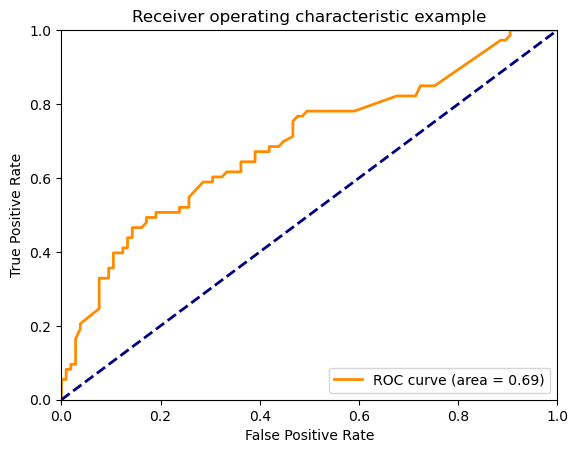

In [91]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = lr.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [95]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'],
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,False,True,False,False,True,False,False,True
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,True,False,True,False,False,True,False,False
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,True,False,False,False,True,False,False,True
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,True,False,False,False,True,True,False,False
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,False,True,False,False,True,False,False,True


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [99]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [102]:
# ANSWER
# Set Feature Both Numerical, Categorical
# Drop Survived (Target Variable), Cabin columns (too many missing value), Name & Ticket (Not useful for prediction), 
X = titanic_with_dummies.drop(columns = ['Survived', 'Cabin', 'Name', 'Ticket'])
X.isnull().sum()

Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Pclass_1      0
Pclass_2      0
Pclass_3      0
dtype: int64

In [104]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         889 non-null    float64
 1   SibSp       889 non-null    int64  
 2   Parch       889 non-null    int64  
 3   Fare        889 non-null    float64
 4   Sex_female  889 non-null    bool   
 5   Sex_male    889 non-null    bool   
 6   Embarked_C  889 non-null    bool   
 7   Embarked_Q  889 non-null    bool   
 8   Embarked_S  889 non-null    bool   
 9   Pclass_1    889 non-null    bool   
 10  Pclass_2    889 non-null    bool   
 11  Pclass_3    889 non-null    bool   
dtypes: bool(8), float64(2), int64(2)
memory usage: 41.7 KB


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [143]:
# Build Model
lr = LogisticRegression()
# Fit Model
lr.fit(X_train, y_train)
# Score
print('Accuracy = {:7.6f}'.format(lr.score(X_train,y_train)))

Accuracy = 0.805907


C:\Users\nsk_z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Plot the ROC curve for the new model:

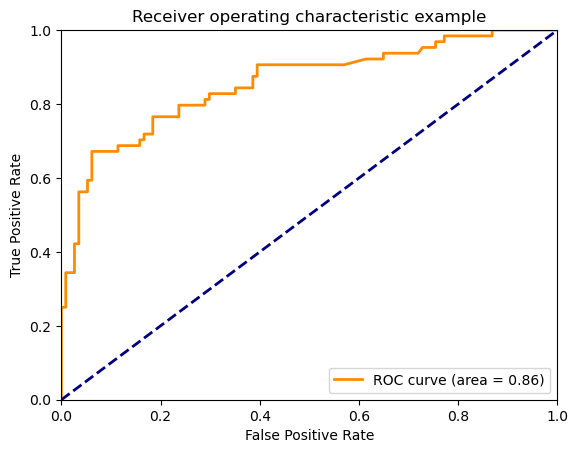

In [146]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = lr.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [160]:
# ANSWER
# Yes, the model improve the accuracy to 0.805907

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change? Accuracy almost same even change the random state.

3. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve? No.

4. Look at the `fpr` & `tpr` vectors for the best model.

In [158]:
# Cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')

print("Scores for each fold:", scores)
print("Mean accuracy:", scores.mean())
print("Standard deviation of accuracy:", scores.std())


Scores for each fold: [0.8041958  0.81690141 0.85211268 0.75352113 0.76760563]
Mean accuracy: 0.7988673298532454
Standard deviation of accuracy: 0.03527678924402832


C:\Users\nsk_z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nsk_z\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_



---



---



> > > > > > > > > © 2025 Institute of Data


---



---



